In [1]:
import os

current_path = os.getcwd()
print(current_path)


/fast/AG_Metzger/daniela/python


In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
from fastai.vision.all import *
from sklearn.metrics import f1_score
import numpy as np
from fastcore import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [5]:

disease_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/fRGB_disease_AACT_Cas3_disease_AACT')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB_wt_AACT_Cas3_wild_typeAACT/')

def get_label(o):
    if o.parent.name == 'fRGB_disease_AACT_Cas3_disease_AACT':
        return 'disease'
    elif o.parent.name == 'fRGB_wt_AACT_Cas3_wild_typeAACT':
        return 'wild_type'
    else:
        raise ValueError(f"Unknown label for {o}")

In [6]:

disease_files = get_image_files(disease_path)
wild_type_files = get_image_files(wild_type_path)
num_samples = min(len(disease_files), len(wild_type_files))
disease_files = disease_files[:num_samples]
wild_type_files = wild_type_files[:num_samples]

files = disease_files + wild_type_files
labels = {**{f:disease_path.name for f in disease_files}, **{f:wild_type_path.name for f in wild_type_files}}

In [7]:
disease_files = get_image_files(disease_path)
wild_type_files = get_image_files(wild_type_path)

num_samples = min(len(disease_files), len(wild_type_files))
disease_files = disease_files[:num_samples]
wild_type_files = wild_type_files[:num_samples]

files = disease_files + wild_type_files
labels = {**{f:disease_path.name for f in disease_files}, **{f:wild_type_path.name for f in wild_type_files}}

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: files,
    splitter=RandomSplitter(valid_pct=0.2, seed=123),
    get_y=get_label,
    item_tfms=[Resize(224)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(source=(disease_path, wild_type_path), bs=16, num_workers=4)

num_val_samples = len(dls.valid_ds)
if num_val_samples == 0:
    raise ValueError("Validation set is empty.")


learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, cbs=[EarlyStoppingCallback(patience=2)])
print(f'The accuracy of the model is {learn.recorder.values[-1][-1]:.2%}.')


val_indices = range_of(dls.valid)
val_files = [files[i] for i in val_indices]
val_preds = learn.get_preds(dl=dls.valid)
mean_preds = val_preds[0].mean()
std_preds = val_preds[0].std()
learn.export('model_tuned_AACT.pkl')

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No improvement since epoch 6: early stopping
The accuracy of the model is 100.00%.


In [12]:
from fastai.learner import load_learner
model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_AACT.pkl')
learn = load_learner(model_path)

In [ ]:
val_preds, val_targs = learn.get_preds(dl=dls.valid)
df_valid = pd.DataFrame({'class': [dls.vocab[i] for i in val_targs], 'prediction': val_preds[:, 0]})
df_valid.to_csv('/fast/AG_Metzger/daniela/python/python_folder/results_train_AACT.csv', index=False)
print("Results saved at: /fast/AG_Metzger/daniela/python/python_folder/results_train_AACT.csv")

Results saved at: /fast/AG_Metzger/daniela/python/python_folder/results_train_AACT.csv


/tmp/6513606.1.gpu.q/ipykernel_46441/473469253.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_valid, x='class', y='prediction', ax=ax, jitter=0.1, palette=['green', 'red'], alpha=0.5)


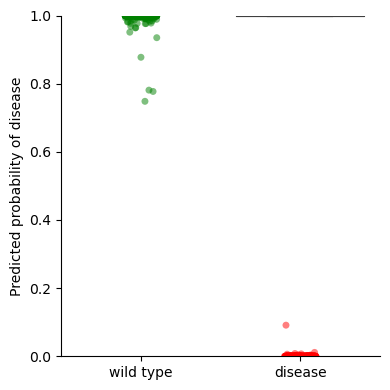

Image saved at: /fast/AG_Metzger/daniela/python/python_folder/aact_probs.jpeg


<Figure size 640x480 with 0 Axes>

In [13]:
class_order = ['wild type', 'disease']

fig, ax = plt.subplots(figsize=(4, 4))  
sns.stripplot(data=df_valid, x='class', y='prediction', ax=ax, jitter=0.1, palette=['green', 'red'], alpha=0.5)
sns.boxplot(data=df_valid, x='class', y='prediction', ax=ax, boxprops={'facecolor': 'None'}, fliersize=0, order=class_order)
sns.despine()
ax.set_xlabel('')
ax.set_ylabel('Predicted probability of disease')
ax.set_ylim([0, 1])
ax.set_xticklabels(class_order)

plt.xticks(rotation=0) 
plt.tight_layout()  
plt.show()


image_path = '/fast/AG_Metzger/daniela/python/python_folder/aact_probs.jpeg'
plt.savefig(image_path, format='jpeg')


print("Image saved at:", image_path)


In [9]:
val_preds, val_targs = learn.get_preds(dl=dls.valid)

df_valid = pd.DataFrame({'class': [dls.vocab[i] for i in val_targs], 'prediction': val_preds[:, 0]})

disease_preds = df_valid[df_valid['class'] == 'disease']['prediction']
wild_type_preds = df_valid[df_valid['class'] == 'wild_type']['prediction']
mean_disease, mean_wild_type = np.mean(disease_preds), np.mean(wild_type_preds)
std_disease, std_wild_type = np.std(disease_preds), np.std(wild_type_preds)

z_prime = 1 - 3*(std_disease + std_wild_type) / abs(mean_disease - mean_wild_type)

print(f'The Z prime score for the validation set is {z_prime:.2f}')


The Z prime score for the validation set is 0.96


In [ ]:
#Rescue files analysis

In [6]:
from fastai.learner import load_learner

model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_AACT.pkl')


learn = load_learner(model_path)



In [ ]:
import dill

In [11]:
test_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/')
model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_AACT.pkl')

learn_inf = load_learner(model_path, pickle_module=dill)

test_files = get_image_files(test_path)
test_dl = learn_inf.dls.test_dl(test_files)
preds, _ = learn_inf.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)


idx2label = {1: 'disease', 0: 'wild_type'}


results = []

for i, (pred_prob, pred_label_idx) in enumerate(zip(preds, pred_labels)):
    pred_label = idx2label[pred_label_idx.item()]
    probability = pred_prob[pred_label_idx].item()
    results.append({'File': test_files[i], 'Predicted Label': pred_label, 'Probability': probability})


df = pd.DataFrame(results)

print(df)

                                                                                                                                                                                    File   
0     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/r06c09_r06c09f17p34.tiff  \
1     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/r05c05_r05c05f05p09.tiff   
2     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/r05c07_r05c07f14p03.tiff   
3     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/r05c05_r05c05f02p07.tiff   
4     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue

In [12]:
test_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/')
model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_AACT.pkl')

learn_inf = load_learner(model_path, pickle_module=dill)

test_files = get_image_files(test_path)
test_dl = learn_inf.dls.test_dl(test_files)
preds, _ = learn_inf.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)


idx2label = {1: 'disease', 0: 'wild_type'}


results = []

for i, (pred_prob, pred_label_idx) in enumerate(zip(preds, pred_labels)):
    pred_label = idx2label[pred_label_idx.item()]
    probability = pred_prob[pred_label_idx].item()
    inverted_probability = 1 - probability  
    results.append({'File': test_files[i], 'Predicted Label': pred_label, 'Probability': probability, '1 - Probability': inverted_probability})


df = pd.DataFrame(results)


print(df)

                                                                                                                                                                                    File   
0     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/r06c09_r06c09f17p34.tiff  \
1     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/r05c05_r05c05f05p09.tiff   
2     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/r05c07_r05c07f14p03.tiff   
3     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/correct_rescue_RGB_CAS3_final_rescue_AACT/r05c05_r05c05f02p07.tiff   
4     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue

In [13]:
treatment_mapping = {
    'c01': 'Control',
    'c02': 'Control',
    'c03': '250 nM Risdiplam',
    'c04': '250 nM Risdiplam',
    'c05': '250 nM Risdiplam',
    'c06': '250 nM Risdiplam',
    'c07': '10 uM Prednisolone',
    'c08': '10 uM Prednisolone',
    'c09': '10 uM Prednisolone + 250 nM Risdiplam'
}


common_names = [f.name.split('_')[0] for f in test_files]
treatments = []
for cn in common_names:
    for code, treatment in treatment_mapping.items():
        if code in cn:
            treatments.append(treatment)
            break
    else:
        treatments.append('Unknown')


df1 = pd.DataFrame({'Common Name': common_names,'Probability': df['Probability'], '1 - Probability': df['1 - Probability'], 'Treatment': treatments})
rescue_scores = df1.groupby('Treatment')['Probability'].mean().reset_index()
std_deviations = df1.groupby('Treatment')['Probability'].std().reset_index()


for treatment, score, std_dev in zip(rescue_scores['Treatment'], rescue_scores['Probability'], std_deviations['Probability']):
    print(f'Treatment: {treatment}, Rescue Score: {score:.4f}, Standard Deviation: {std_dev:.4f}')


Treatment: 10 uM Prednisolone, Rescue Score: 0.9917, Standard Deviation: 0.0392
Treatment: 10 uM Prednisolone + 250 nM Risdiplam, Rescue Score: 0.9849, Standard Deviation: 0.0537
Treatment: 250 nM Risdiplam, Rescue Score: 0.9579, Standard Deviation: 0.0976


In [14]:
df1

Common Name  Probability  1 - Probability   
0         r06c09     0.999008     9.924769e-04  \
1         r05c05     0.993433     6.567478e-03   
2         r05c07     0.904463     9.553659e-02   
3         r05c05     0.997334     2.665997e-03   
4         r05c07     0.953714     4.628557e-02   
...          ...          ...              ...   
5245      r05c07     0.987360     1.263970e-02   
5246      r05c09     0.999995     5.483627e-06   
5247      r05c09     0.592399     4.076015e-01   
5248      r05c07     0.987761     1.223850e-02   
5249      r05c07     0.999999     8.344650e-07   

                                  Treatment  
0     10 uM Prednisolone + 250 nM Risdiplam  
1                          250 nM Risdiplam  
2                        10 uM Prednisolone  
3                          250 nM Risdiplam  
4                        10 uM Prednisolone  
...                                     ...  
5245                     10 uM Prednisolone  
5246  10 uM Prednisolone + 250 nM Risdiplam  
5247  10 uM Prednisolone + 250 nM Risdiplam  
5248                     10 uM Prednisolone  
5249                     10 uM Prednisolone  

[5250 rows x 4 columns]

In [15]:
df1_copy = df1[['Treatment', '1 - Probability']].copy()
df1_copy

Treatment  1 - Probability
0     10 uM Prednisolone + 250 nM Risdiplam     9.924769e-04
1                          250 nM Risdiplam     6.567478e-03
2                        10 uM Prednisolone     9.553659e-02
3                          250 nM Risdiplam     2.665997e-03
4                        10 uM Prednisolone     4.628557e-02
...                                     ...              ...
5245                     10 uM Prednisolone     1.263970e-02
5246  10 uM Prednisolone + 250 nM Risdiplam     5.483627e-06
5247  10 uM Prednisolone + 250 nM Risdiplam     4.076015e-01
5248                     10 uM Prednisolone     1.223850e-02
5249                     10 uM Prednisolone     8.344650e-07

[5250 rows x 2 columns]

In [26]:
df_valid


class  prediction  1 - prediction class_label
0      disease    0.999982        0.000018   wild type
1      disease    0.993606        0.006394   wild type
2      disease    0.999946        0.000054   wild type
3      disease    0.998285        0.001715   wild type
4    wild_type    0.000729        0.999271     disease
..         ...         ...             ...         ...
702    disease    0.995345        0.004655   wild type
703    disease    0.999985        0.000015   wild type
704  wild_type    0.000267        0.999733     disease
705    disease    0.999987        0.000013   wild type
706    disease    0.999415        0.000585   wild type

[707 rows x 4 columns]

In [29]:
df_valid = df_valid.rename(columns={'class_label': 'Treatment', '1 - prediction': '1 - Probability'})
df_valid

class  prediction  1 - Probability  Treatment
0      disease    0.999982         0.000018  wild type
1      disease    0.993606         0.006394  wild type
2      disease    0.999946         0.000054  wild type
3      disease    0.998285         0.001715  wild type
4    wild_type    0.000729         0.999271    disease
..         ...         ...              ...        ...
702    disease    0.995345         0.004655  wild type
703    disease    0.999985         0.000015  wild type
704  wild_type    0.000267         0.999733    disease
705    disease    0.999987         0.000013  wild type
706    disease    0.999415         0.000585  wild type

[707 rows x 4 columns]

In [30]:
combined_df = pd.concat([df1_copy, df_valid])
combined_df

Treatment  1 - Probability      class   
0    10 uM Prednisolone + 250 nM Risdiplam         0.000992        NaN  \
1                         250 nM Risdiplam         0.006567        NaN   
2                       10 uM Prednisolone         0.095537        NaN   
3                         250 nM Risdiplam         0.002666        NaN   
4                       10 uM Prednisolone         0.046286        NaN   
..                                     ...              ...        ...   
702                              wild type         0.004655    disease   
703                              wild type         0.000015    disease   
704                                disease         0.999733  wild_type   
705                              wild type         0.000013    disease   
706                              wild type         0.000585    disease   

     prediction  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
702    0.995345  
703    0.999985  
704    0.000267  
705    0.999987  
706    0.999415  

[5957 rows x 4 columns]

/tmp/6637046.1.gpu.q/ipykernel_206918/1567281945.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=combined_df, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)


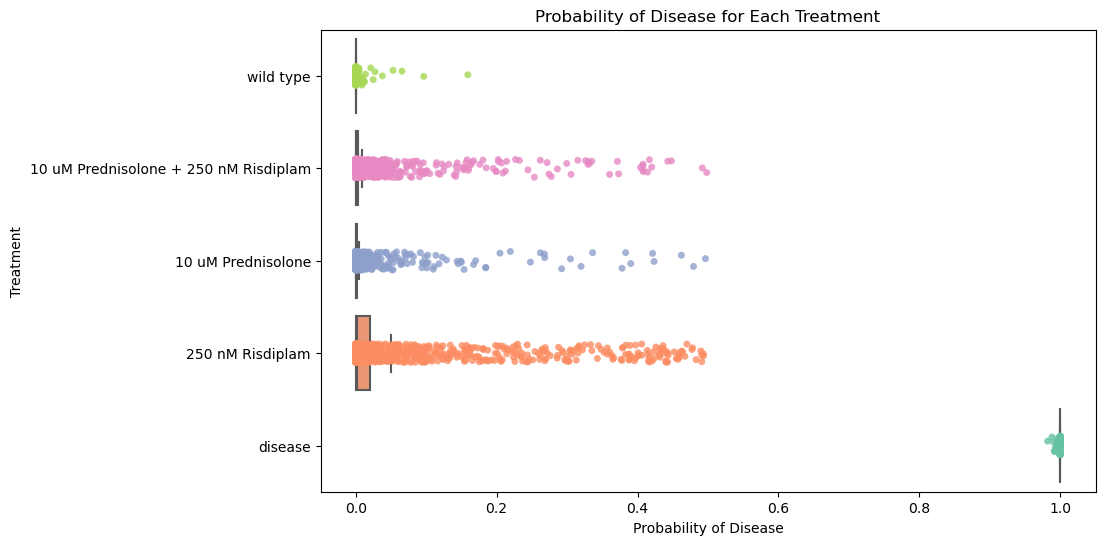

In [31]:
desired_order = ['disease', '250 nM Risdiplam', '10 uM Prednisolone', '10 uM Prednisolone + 250 nM Risdiplam', 'wild type']
combined_df['Treatment'] = pd.Categorical(combined_df['Treatment'], categories=desired_order, ordered=True)


fig, ax = plt.subplots(figsize=(10, 6))
treatment_palette = sns.color_palette('Set2', n_colors=len(desired_order))
sns.boxplot(data=combined_df, x='1 - Probability', y='Treatment', ax=ax, showfliers=False, palette=treatment_palette)
sns.stripplot(data=combined_df, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)
ax.set_xlabel('Probability of Disease')
ax.set_ylabel('Treatment')
ax.set_title('Probability of Disease for Each Treatment')
ax.invert_yaxis()
plt.show()

In [ ]:
#saliency  maps

In [ ]:
from fastai.vision.all import *
from sklearn.metrics import f1_score
import numpy as np
from fastcore import *
from captum.attr import Saliency
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageEnhance, ImageOps


In [17]:
disease_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/fRGB_disease_AACT_Cas3_disease_AACT')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB_wt_AACT_Cas3_wild_typeAACT/')

def get_label(o):
    if o.parent.name == 'fRGB_disease_AACT_Cas3_disease_AACT':
        return 'disease'
    elif o.parent.name == 'fRGB_wt_AACT_Cas3_wild_typeAACT':
        return 'wild_type'
    else:
        raise ValueError(f"Unknown label for {o}")

disease_files = get_image_files(disease_path)
wild_type_files = get_image_files(wild_type_path)

num_samples = min(len(disease_files), len(wild_type_files))
disease_files = disease_files[:num_samples]
wild_type_files = wild_type_files[:num_samples]

files = disease_files + wild_type_files
labels = {**{f:disease_path.name for f in disease_files}, **{f:wild_type_path.name for f in wild_type_files}}

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: files,
    splitter=RandomSplitter(valid_pct=0.2, seed=123),
    get_y=get_label,
    item_tfms=[Resize(224)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(source=(disease_path, wild_type_path), bs=16, num_workers=4)

num_val_samples = len(dls.valid_ds)
if num_val_samples == 0:
    raise ValueError("Validation set is empty.")


learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, cbs=[EarlyStoppingCallback(patience=2)])
print(f'The accuracy of the model is {learn.recorder.values[-1][-1]:.2%}.')

val_indices = range_of(dls.valid)
val_files = [files[i] for i in val_indices]

val_preds = learn.get_preds(dl=dls.valid)


sample_idx = 0  
sample_image = PILImage.create(val_files[sample_idx]).convert('RGB')  


preprocess = learn.dls.after_item
sample = preprocess(sample_image)


input_tensor = to_tensor(sample).unsqueeze(0)


input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No improvement since epoch 3: early stopping
The accuracy of the model is 100.00%.


/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


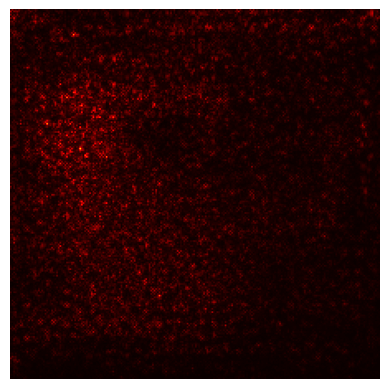

r05c01_r05c01f22p13


In [18]:
sample_idx = 0 
sample_image = PILImage.create(val_files[sample_idx]).convert('RGB')  

preprocess = learn.dls.after_item
sample = preprocess(sample_image)


input_tensor = to_tensor(sample).unsqueeze(0)


input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)

class_labels = ['disease', 'wild_type']  

target_index = class_labels.index('disease')  


saliency_map = saliency.attribute(input_tensor, target=target_index)


normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

gray_map = np.mean(normalized_map.squeeze().cpu().detach().numpy(), axis=0)
plt.imshow(gray_map, cmap='hot', vmin=0, vmax=1)
plt.axis('off')
plt.show()
sample_id = val_files[sample_idx].stem
print(sample_id)

In [ ]:
file_path = ('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB_wt_AACT_Cas3_wild_typeAACT/r01c02_r01c02f06p10.tiff')
original_image = PILImage.create(file_path).convert('RGB')

contrast_factor = 8.5  
enhancer = ImageEnhance.Contrast(original_image)
enhanced_image = enhancer.enhance(contrast_factor)

preprocess = learn.dls.after_item
sample = preprocess(enhanced_image)

In [ ]:
input_tensor = to_tensor(sample).unsqueeze(0)
input_tensor = input_tensor.to(learn.dls.device)
saliency = Saliency(learn.model)
target_index = class_labels.index('wild_type')  

In [ ]:
saliency_map = saliency.attribute(input_tensor, target=target_index)
normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
red_channel_score = np.mean(normalized_map[:, 0].squeeze().cpu().detach().numpy())
green_channel_score = np.mean(normalized_map[:, 1].squeeze().cpu().detach().numpy())
blue_channel_score = np.mean(normalized_map[:, 2].squeeze().cpu().detach().numpy())


In [ ]:
total_saliency_score = red_channel_score + green_channel_score + blue_channel_score

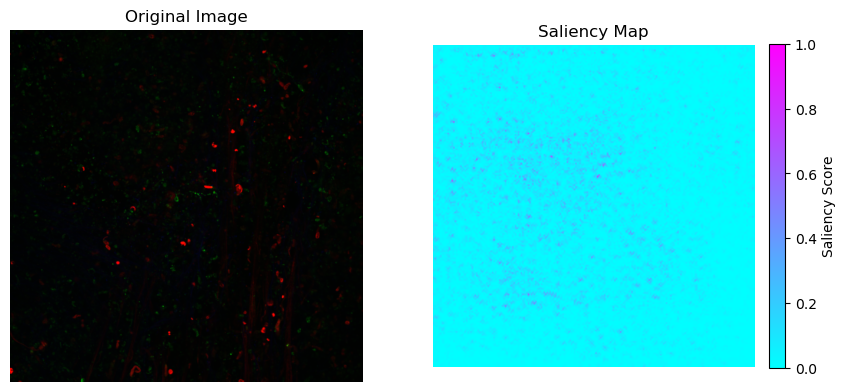

File path of the original image: /fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB_wt_AACT_Cas3_wild_typeAACT/r01c02_r01c02f06p10.tiff


In [9]:
from PIL import ImageOps
file_path= ('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB_wt_AACT_Cas3_wild_typeAACT/r01c02_r01c02f06p10.tiff')

original_image = PILImage.create(file_path).convert('RGB')
preprocess = learn.dls.after_item
sample = preprocess(original_image)


input_tensor = to_tensor(sample).unsqueeze(0)
input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)


class_labels = ['disease', 'wild_type'] 
target_index = class_labels.index('wild_type') 


saliency_map = saliency.attribute(input_tensor, target=target_index)
normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
gray_map = np.mean(normalized_map.squeeze().cpu().detach().numpy(), axis=0)
resized_saliency_map = ImageOps.fit(PILImage.create(gray_map), original_image.size)
resized_saliency_map = np.array(resized_saliency_map)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[0].axis('off')
im = axs[1].imshow(resized_saliency_map, cmap='cool', vmin=0, vmax=1)
axs[1].set_title('Saliency Map')
axs[1].axis('off')
cbar = plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_label('Saliency Score')
plt.show()

print("File path of the original image:", file_path)


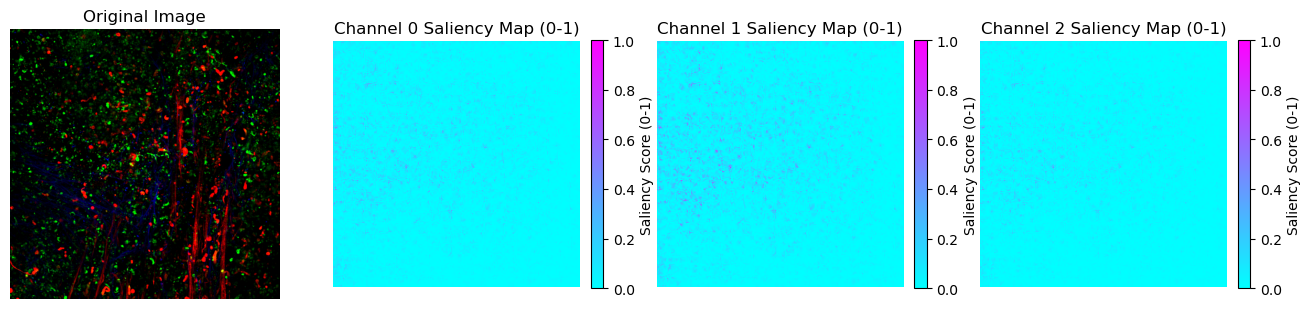

In [17]:
file_path = ('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/fRGB_wt_AACT_Cas3_wild_typeAACT/r01c02_r01c02f06p10.tiff')
original_image = PILImage.create(file_path).convert('RGB')
contrast_factor = 8.5  
enhancer = ImageEnhance.Contrast(original_image)
enhanced_image = enhancer.enhance(contrast_factor)

preprocess = learn.dls.after_item
sample = preprocess(enhanced_image)


input_tensor = to_tensor(sample).unsqueeze(0)
input_tensor = input_tensor.to(learn.dls.device)

saliency = Saliency(learn.model)
target_index = class_labels.index('wild_type')  
saliency_map = saliency.attribute(input_tensor, target=target_index)
normalized_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

threshold_mask = normalized_map >= 0.5


fig, axs = plt.subplots(1, 4, figsize=(16, 5))  
axs[0].imshow(enhanced_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

for channel in range(3):
    axs[channel + 1].imshow(normalized_map.squeeze()[channel].cpu().detach().numpy(), cmap='cool', vmin=0, vmax=1)
    axs[channel + 1].set_title(f'Channel {channel} Saliency Map (0-1)')
    axs[channel + 1].axis('off')

for ax in axs[1:]:
    cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Saliency Score (0-1)')

plt.show()


/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


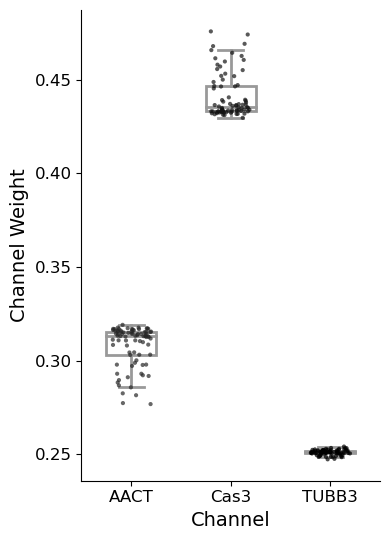

In [21]:
fig, ax = plt.subplots(figsize=(4, 5.5))
channels = ['AACT', 'Cas3', 'TUBB3']
combined_weights = np.vstack((red_channel_weights, green_channel_weights, blue_channel_weights)).T
weights_df = pd.DataFrame(data=combined_weights, columns=channels)
sns.boxplot(data=weights_df, ax=ax, width=0.5, color='white', fliersize=0, linewidth=2)  
sns.stripplot(data=weights_df, ax=ax, jitter=0.2, size=3, alpha=0.7, color='black')  
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_ylabel('Channel Weight', fontsize=14)
ax.set_xlabel('Channel', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
